Text shazam

Data gathering

analysis of 2 or 3 different kind of algorithms we will use: kNN, maxent, logistic regression, deep learning, and support vector machines.

each method has a different pre processing and strengths and interpretatio


kNN- tokenizing, all lower case, removing common words, lematisize, tagging words as preposition/conjunction/etc,  TF IDF

Do we remove stop words, or not?
Do we stem or lemmatize our text data, or leave the words as is?
Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
Do we stick with English words only or do we allow for other languages?
Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?

In [46]:
#imports
#import subprocess
#subprocess.call(['pip', 'install', 'nltk'])
#subprocess.call(['pip', 'install', 'textblob'])
#!pip install gensim

import numpy as np
from textblob import TextBlob
import random
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.neighbors
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
import re
import os
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
from scipy.interpolate import make_interp_spline
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

#set working directory
os.chdir('/home/jovyan/persistent/CSE204/FINAL_PROJECT')


In [47]:
def read_file(file_path):
    
    with open(file_path, 'r') as file:
        text = file.read()
    return text

In [48]:
#get the data

path_to_songs = os.path.join(os.getcwd(), "Raw_Songs_DataBase")

artists = os.listdir(path_to_songs)
artists = [art for art in artists if art[0] != "."]
artists = sorted(artists)

x = []
y = []

songs_per_artist={art : 0 for art in artists}

titles = []

for art in artists: 
    

    path_to_artist = os.path.join(path_to_songs, art)
    path_to_artist_songs = os.path.join(path_to_artist, "Songs")
    
    songs = os.listdir(path_to_artist_songs)
    for song in songs:
        if song[0] != "." :
            path = os.path.join(path_to_artist_songs, song)
            titles.append(song)
            lyrics =  read_file(path)
            x.append(lyrics)
            songs_per_artist[art] += 1
            y.append(art)
            
    
arts_dict = {}
for i in range(len(artists)):
    arts_dict[artists[i]] = i
    
for i in range(len(y)):
    art = y[i]
    y[i] = int(arts_dict[art])

x = np.array(x)
y = np.array(y) 
titles = np.array(titles)
    
def shuffle(x, y, titles):
    perm = np.random.permutation(len(x))
    x = x[perm]
    y = y[perm]
    titles = titles[perm]
    return x, y, titles

x, y, titles = shuffle(x,y, titles)

Now let us get some data about the songs

Number of songs : 1455
Number of artists : 15
Average number of songs per artist : 97


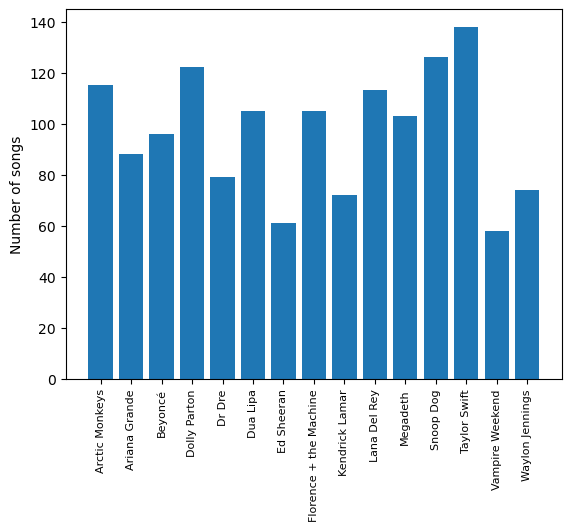

In [49]:
print(f'Number of songs : {len(x)}')
print(f'Number of artists : {len(artists)}')
print(f'Average number of songs per artist : {int(len(x)/len(artists))}')

keys = songs_per_artist.keys()
values = songs_per_artist.values()

plt.bar(keys, values)

plt.ylabel('Number of songs')
plt.xticks(rotation='vertical', fontsize = 8)

plt.show()

In [50]:

def pre_processing(text):
    
    text = text.lower() #lowercase
    
    #get number of lines
    nb_lines = text.count("\n")
    
    #split in lines
    text = text.split("\n") 
    
    #remove useless punctuation
    punctuation = r'[/()-.?!,";]'
    text= [re.sub(punctuation,"", sentence) for sentence in text]
    
    #seperate each word (but we keep expressions in brackets together)
    pattern = r'\[.*?\]|\S+'
    text = [re.findall(pattern, sentence) for sentence in text]
    
    #flatten the list of lists
    text = [word for sentence in text for word in sentence]
    
    #remove all expressions in between brackets and empty words
    text = [word for word in text if len(word) != 0 and word[0]!= "["]
    
    #stemmatization
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text]
    
    nb_words = len(text)


    return text, nb_lines, nb_words

def title_pre_processing(title):
    
    title = title.lower() #lowercase
    
    
    #remove useless punctuation
    punctuation = r'[-.?!,";/]'
    title = re.sub(punctuation,"", title)
    

    #seperate each word (but we keep expressions in brackets and in parenthesis together)
    pattern = r'\[.*?\]|\(.*?\)|\S+'
    title = re.findall(pattern, title)
    
    #remove all expressions in between brackets and empty words
    title = [word for word in title if len(word) != 0 and word[0] not in  {"[", "("}]
    
    
    #stemmatization
    ps = PorterStemmer()
    title = [ps.stem(word) for word in title]
    
    return title

Let's vizualize the data

In [51]:
data = []
for i in range(len(x)):
    song = x[i]
    point = list(pre_processing(song))
    t = title_pre_processing(titles[i])
    point.append(t)
    point.append(y[i])
    data.append(point)

#df = pd.DataFrame(data, columns=['Lyrics', 'Nb_Lines', 'Nb_Words', 'Artist'])
  

In [52]:
df = pd.DataFrame(data, columns=['Lyrics', 'Nb_Lines', 'Nb_Words', 'Title', 'Artist'])
df.head()

,Lyrics,Nb_Lines,Nb_Words,Title,Artist
0,"[i'm, sorri, i, ruin, your, birthday, i, guess...",55,321,[grace],7
1,"[stop, the, world, and, let, me, off, i'm, tir...",24,118,"[stop, the, world]",14
2,"[we, were, in, the, backseat, drunk, on, somet...",64,378,"[cornelia, street]",12
3,"[you, got, your, hp, lovecraft, your, edgar, a...",53,204,"[you'r, so, dark]",0
4,"[you, are, the, hole, in, my, head, you, are, ...",79,389,"[no, light, no, light]",7


In [53]:
sample = random.sample(range(len(artists)), 10)

def plot_box_graph(features):
    
    nb_graphs = len(features)
    
    if nb_graphs == 1:
        feature = features[0]
        to_plot = []
        for art in sample:
            d1 = df.loc[df['Artist'] == art, feature]
            to_plot.append(d1.tolist())

        plt.boxplot(to_plot)
        xtick_labels = [artists[i] for i in sample]
        plt.gca().set_xticklabels(xtick_labels, rotation='vertical', fontsize=8)
        plt.title(feature)

        plt.show()
    else:
        fig, graphs = plt.subplots(1, nb_graphs, figsize=(10, 4), gridspec_kw={'wspace': 0.3})
    
        plots = [[] for _ in range(nb_graphs)]

        for art in sample:
            for i in range(len(features)):
                feature = features[i]
                d = df.loc[df['Artist'] == art, feature]
                plots[i].append(d)
        
        for i in range(len(plots)):
            graphs[i].boxplot(plots[i])
                


        xtick_labels = [artists[i] for i in sample]
        
        for i in range(len(features)):
            feature = features[i]
            graphs[i].set_xticklabels(xtick_labels, rotation='vertical', fontsize=8)
            graphs[i].set_title(feature)

        
        plt.show()
        
def plot_bar_graph(feature):
    
    to_plot = []
    for art in sample:
        d1 = df.loc[df['Artist'] == art, feature]
        to_plot.append(d1.mean())  # Append the mean value instead of the list of values

    plt.bar(np.arange(len(to_plot)), to_plot)  # Provide positions and values to plt.bar()
    xtick_labels = [artists[i] for i in sample]
    plt.xticks(np.arange(len(to_plot)), xtick_labels, rotation='vertical', fontsize=8)  # Use plt.xticks() for setting x-tick labels
    plt.title(feature)

    plt.show()

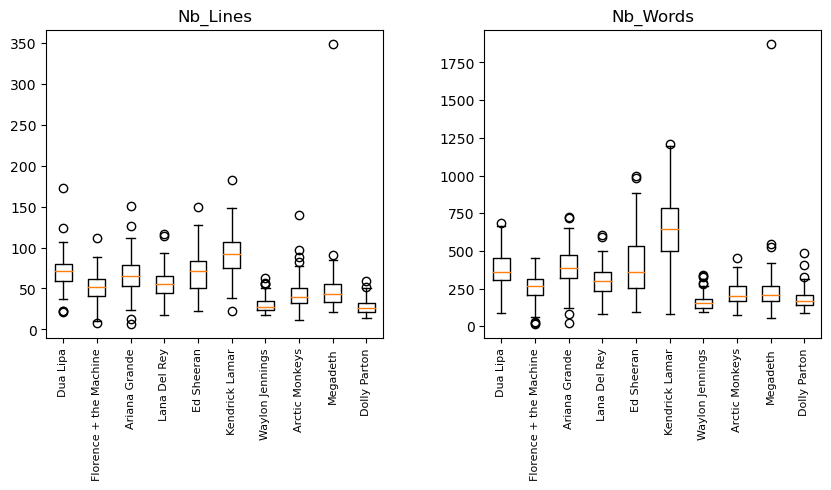

In [54]:
plot_box_graph(["Nb_Lines", "Nb_Words"])

We add a new feature: Type-Token ratio. It shows how repetitive a song is.

In [55]:
songs = df["Lyrics"].to_list()

TTR = []
for song in songs:
    dic={word : 0 for word in song}
    non_unique_words = set()
    for word in song:
        dic[word]+=1
        if dic[word] > 1:
            non_unique_words.add(word)
    song_len = len(song)
    nb_unique_words = song_len - len(non_unique_words)
    ttr = nb_unique_words/song_len
    TTR.append(ttr)
    
df['TTR'] = TTR

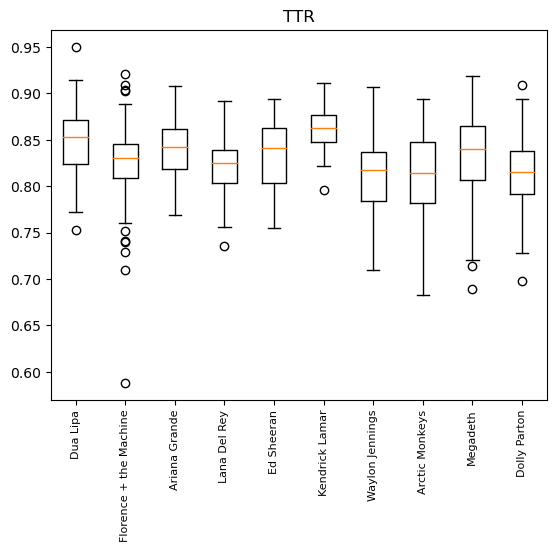

In [56]:
plot_box_graph(["TTR"])

Now we analyze prononces. We count the frequencies of 1st, 2nd, 3rd person pronons and the ratio of 1st person to 2d person to detect dialogue and interpersonal relations.

In [57]:
path = os.path.join(os.getcwd(), "rare-filtered.txt")
rare = read_file(path)
rare = rare.split("\n")
rare = rare[:-1]

path = os.path.join(os.getcwd(), "slang-filtered.txt")
slang = read_file(path)
slang = slang.split("\n")
slang = slang[:-1]

slang = set(slang)
rare = set(rare)

rare_use = []
slang_use = []

for song in songs:

    count_r = 0
    count_s = 0
    l = len(song)
    for w in song:
        if w in slang:
            count_s += 1
        if w in rare:
            count_r +=1
    slang_use.append(count_s/l)
    rare_use.append(count_r/l)
    

df['Slang'] = slang_use
df['Rare'] = rare_use

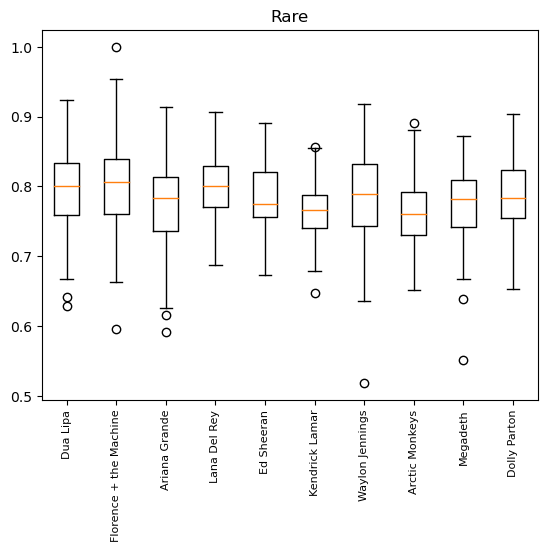

In [58]:
plot_box_graph(["Rare"])

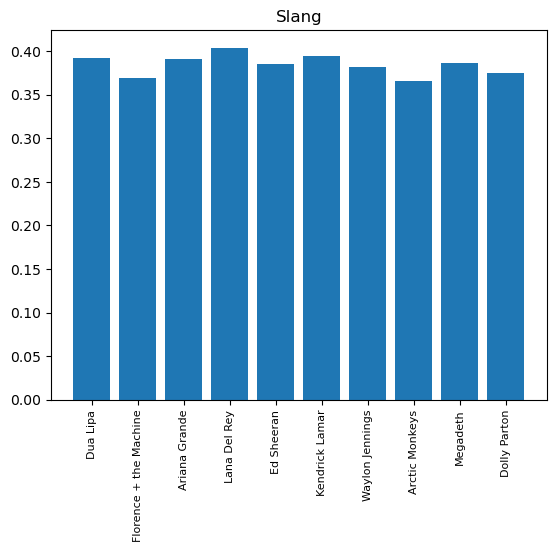

In [59]:
plot_bar_graph("Slang")

In [60]:
first_pers = []
second_pers = []
third_pers = []

for song in songs:
    first_pers_count = 0
    second_pers_count = 0
    third_pers_count = 0

    for word in song:
        if word in  {"i", "we"}:
            first_pers_count += 1
        if word == "you":
            second_pers_count += 1
        if word in  {"he", "she", "they"}:
            third_pers_count += 1
    
    song_len = len(song)
    first_pers.append(first_pers_count/song_len)
    second_pers.append(second_pers_count/song_len)
    third_pers.append(third_pers_count/song_len)
    
df['FP_Freq'] = first_pers
df['SP_Freq'] = second_pers
df['TP_Freq'] = third_pers

df["SR"] = df['FP_Freq']/(1 + df['SP_Freq'] + df['TP_Freq'])

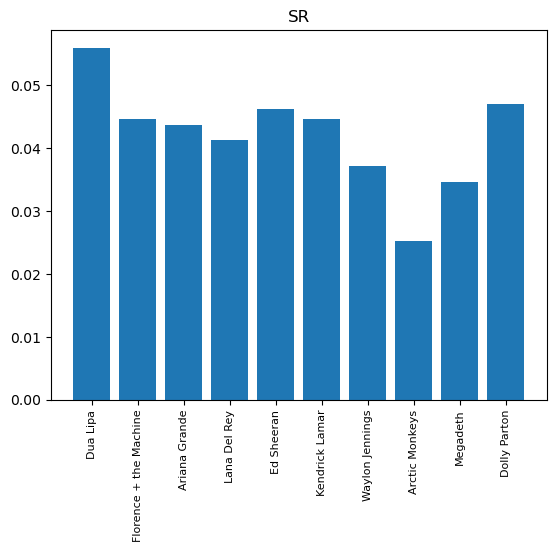

In [61]:
plot_bar_graph("SR")

Now we check whether or not the title appears in the song.

In [62]:
ttls = df["Title"].to_list()

string_songs = [' '.join(song) for song in songs]
string_titles = [' '.join(title) for title in ttls]
title_in_song = []

for song, title in zip(string_songs, string_titles):
       
    if re.search(title, song):
        flag = True
    else:
        flag = False
    title_in_song.append(flag)

df['Title_In_Song'] = title_in_song
                

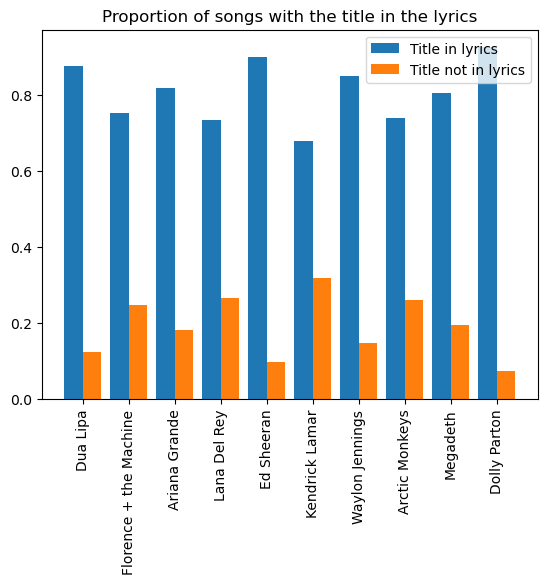

In [63]:
t_in = []
t_not_in = []
total_songs = []

for art in sample:
    songs_by_artist = df.loc[df['Artist'] == art, 'Title_In_Song'].tolist()
    tr = songs_by_artist.count(True)
    fa = songs_by_artist.count(False)
    total_songs.append(len(songs_by_artist))
    t_in.append(tr)
    t_not_in.append(fa)

xtick_labels = [artists[i] for i in sample]

X_axis = np.arange(len(xtick_labels))

t_in = np.array(t_in)
t_not_in = np.array(t_not_in)
total_songs = np.array(total_songs)


plt.bar(X_axis - 0.2, t_in/total_songs, 0.4, label='Title in lyrics')
plt.bar(X_axis + 0.2, t_not_in/total_songs, 0.4, label='Title not in lyrics')

plt.xticks(X_axis, xtick_labels, rotation='vertical')
plt.title('Proportion of songs with the title in the lyrics')
plt.legend()
plt.show()
    

Now, let add tf-idf.

In [64]:
documents = []
for i in range(len(artists)):
    d = df.loc[df['Artist'] == i, 'Lyrics'].tolist()
    d = [word for song in d for word in song]
    documents.append(d)
    
    
documents = [' '.join(doc) for doc in documents]

df_docs = pd.DataFrame({"All_Lyrics" : documents, 
                        "Artist" : np.arange(len(artists))})

df_docs.head()

,All_Lyrics,Artist
0,you got your hp lovecraft your edgar allan poe...,0
1,hmm you might think i'm crazi the way i'v been...,1
2,i love to see you walk into the room bodi shin...,2
3,now littl will wa from the hill way back in th...,3
4,california love california know how to parti c...,4


At this point we need to seperate train and test sets.

In [65]:
total_size = len(x)
test_size = int(0.20*total_size)

In [66]:
train_songs = string_songs[:-test_size]

cv = CountVectorizer()
stem_count_vector = cv.fit_transform(string_songs)

tfidf_transformer = TfidfTransformer()
tfidf_vector = tfidf_transformer.fit_transform(stem_count_vector)

df_word_weights = pd.DataFrame({'word': cv.get_feature_names_out(), 'weight': tfidf_transformer.idf_})
 
df_word_weights.sort_values('weight').head()

,word,weight
11242,the,1.029978
539,and,1.057967
11428,to,1.060882
12727,you,1.071891
5913,it,1.150951


In [67]:
df_word_weights.sort_values('weight', ascending=False).head()

,word,weight
12776,zzz,7.590301
4523,freshest,7.590301
4610,fuzzi,7.590301
4609,fuzz,7.590301
4608,futura,7.590301


In [68]:
tf_idf_vector = tfidf_transformer.transform(stem_count_vector)
tf_idf_matrix = tf_idf_vector.todense()
df_tfidf = pd.DataFrame(tf_idf_matrix, columns=cv.get_feature_names_out())
df_tfidf['Artist'] = df['Artist']
df_tfidf.head()

,00,01,02,04,05,06,09,10,100,1000,...,zip,ziploc,zipper,zone,zonedon,zoo,zoom,zoot,zzz,Artist
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7


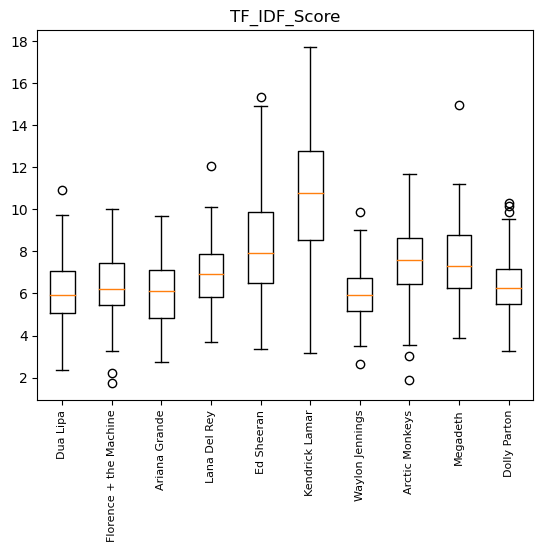

In [69]:
scores = df_tfidf.drop('Artist', axis=1).sum(axis=1)
df["TF_IDF_Score"] = scores

plot_box_graph(["TF_IDF_Score"])

In [70]:
sub = []
pol = []
for song in string_songs:
    scores = TextBlob(song)
    pol.append(scores.sentiment.polarity)
    sub.append(scores.sentiment.subjectivity)
    
df["Polarity"] = pol
df["Subjectivity"] = sub
    

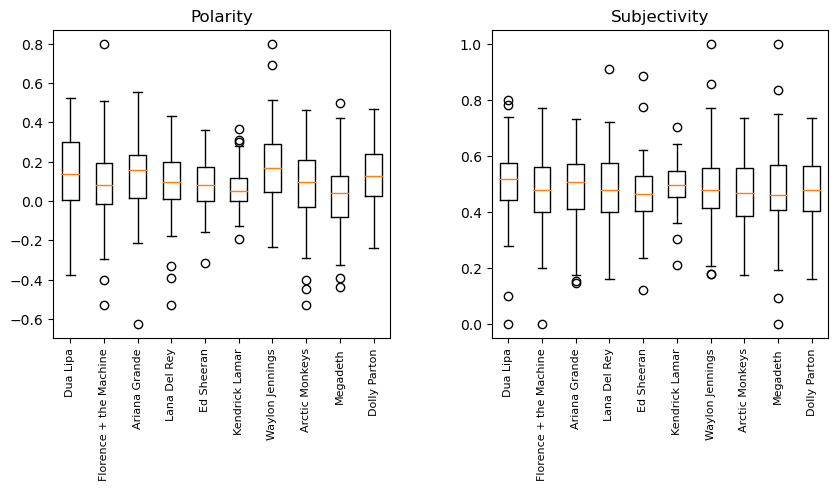

In [71]:
plot_box_graph(["Polarity", "Subjectivity"])

Start coding after this cell but don't delete the following cells.

We want a dataframe with the top 500 best words

In [72]:
# Select the columns that satisfy the condition
selected_columns = [column for column in df_tfidf.columns if 2 < df_tfidf[column].astype(bool).sum() < 100]

# Create a new DataFrame with the selected columns
df_2 = pd.concat([df_tfidf[column] for column in selected_columns], axis=1)

# Display the new DataFrame
df_2


,10,100,11,12,13,14,15,16,17,18,...,youth,yuh,yup,zag,zero,zig,zip,zone,zoo,zoom
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.055301,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.321747
1451,0.029014,0.0,0.0,0.0,0.0,0.0,0.0,0.068881,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1452,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1453,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [73]:
dfdfsorted = df_word_weights.sort_values('weight', ascending=False)
dfdfsorted

,word,weight
12776,zzz,7.590301
4523,freshest,7.590301
4610,fuzzi,7.590301
4609,fuzz,7.590301
4608,futura,7.590301
...,...,...
5913,it,1.150951
12727,you,1.071891
11428,to,1.060882
539,and,1.057967


In [74]:
columns_to_add = []
for index, value in dfdfsorted.iloc[:, 0].items():
    if len(columns_to_add)>=1450:
        break
    if value in df_2.columns:
        columns_to_add.append(value)

In [75]:
df_filtered = pd.concat([df_2[columns_to_add]], axis=1)
df_filtered

,sling,slipper,slider,traffick,awok,badg,fled,awaken,forgiven,eleg,...,squad,sweetheart,soap,thump,breast,staci,devast,sweeter,eighti,de
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


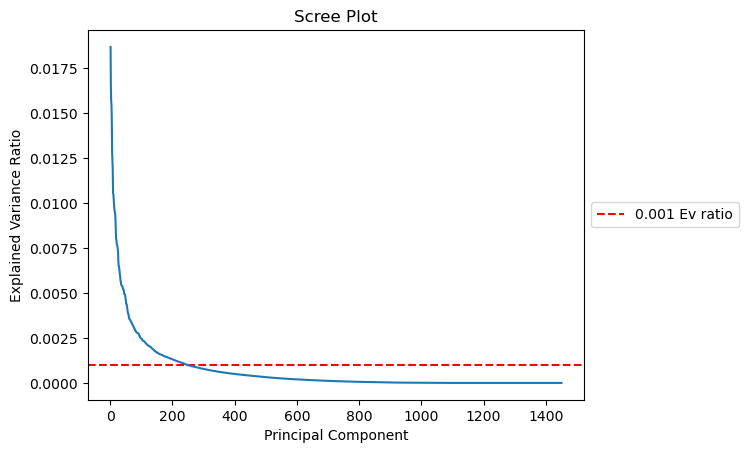

In [76]:

# Perform PCA
pca = PCA()
pca.fit(df_filtered)
df_transformed = pca.transform(df_filtered)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

plt.axhline(y=0.001, color='r', linestyle='--', label='0.001 Ev ratio')

# Create scree plot
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='', linestyle='-')



plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



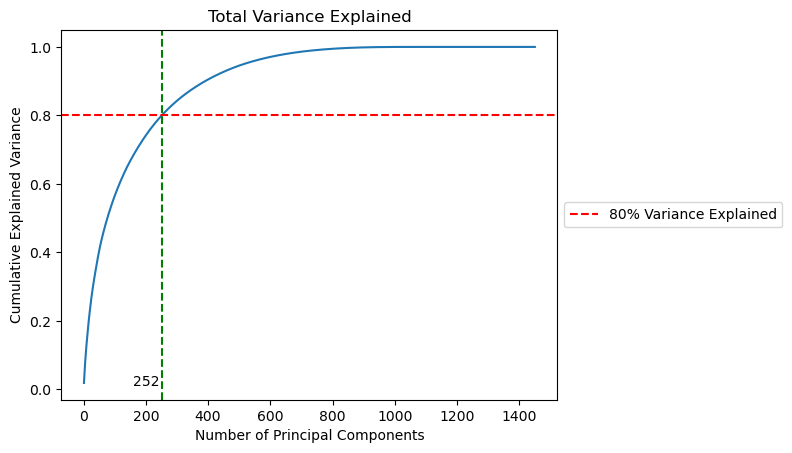

In [77]:
# Calculate cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
# Create total variance explained plot with a line
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Total Variance Explained')
# Add a line at 80% cumulative explained variance
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variance Explained')
plt.legend()
# Find the index where cumulative variance exceeds 98%
idx = next(x for x, value in enumerate(cumulative_variance) if value >= 0.8)
# Add a vertical line at the intersection point
plt.axvline(x=idx + 1, color='g', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot the index of intersection on the x-axis
plt.text(idx - 50, 0.01, f'{idx + 1}', ha='center')

plt.show()

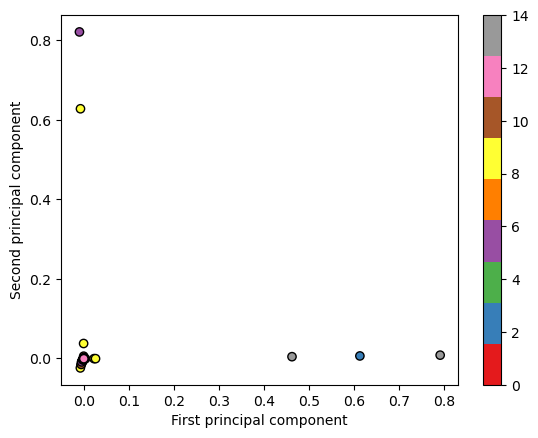

In [78]:
pca = PCA(n_components = 250)
df_transformed = pca.fit_transform(df_filtered)
X_transformed = pca.transform(df_filtered)
plt.scatter(X_transformed[:, 0], 
            X_transformed[:, 1], 
            c=y, 
            cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.colorbar()

In [79]:
pca.explained_variance_ratio_

array([0.01867894, 0.016439  , 0.0156589 , 0.01542868, 0.01451539,
       0.01281756, 0.01236519, 0.01184508, 0.01053632, 0.01049607,
       0.01023403, 0.00999159, 0.00969749, 0.00955856, 0.00946514,
       0.00936221, 0.00897832, 0.00830892, 0.00796839, 0.00794946,
       0.00769481, 0.00766158, 0.00760127, 0.00747413, 0.00731204,
       0.00675121, 0.00651114, 0.00648024, 0.00634503, 0.00614529,
       0.00600244, 0.00591693, 0.00567547, 0.00563479, 0.00546789,
       0.00542548, 0.00539835, 0.00539171, 0.00537213, 0.00530494,
       0.00522456, 0.00521874, 0.00515754, 0.00506947, 0.00494166,
       0.00493266, 0.00491717, 0.00487556, 0.00471167, 0.00460808,
       0.00439972, 0.00438525, 0.00436107, 0.00421891, 0.00410344,
       0.00399108, 0.00385302, 0.00384298, 0.00378472, 0.00363375,
       0.0035758 , 0.00353945, 0.00353418, 0.00351278, 0.0034536 ,
       0.00343368, 0.00340913, 0.00335233, 0.00332156, 0.0033094 ,
       0.00327595, 0.0032046 , 0.00318689, 0.00316758, 0.00312

In [80]:
pcadf =  pd.DataFrame(data = X_transformed)
pcadf.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,-0.001293,-0.001010,-0.000913,-0.000967,0.000149,-0.001233,-0.000297,-0.000843,0.000522,-0.001725,...,-0.002952,-0.006129,0.004419,0.004054,-0.000499,-0.003326,0.005552,-0.008240,0.005617,-0.000176
1,-0.001154,-0.000868,-0.000751,-0.001009,-0.001080,-0.000999,-0.000595,-0.000716,0.000527,-0.001257,...,-0.000595,-0.000022,0.000093,-0.000003,-0.000099,0.000017,0.000379,0.000089,-0.000028,-0.000386
2,-0.001228,-0.000932,-0.000809,-0.001089,-0.001173,-0.001091,-0.000658,-0.000775,0.000464,-0.001298,...,-0.002018,0.003207,0.002954,-0.000250,0.000295,-0.005847,0.009136,-0.004442,0.001443,0.001041
3,-0.001469,-0.001147,-0.001009,-0.001359,-0.001494,-0.001452,-0.000884,-0.001087,0.000765,-0.001966,...,0.002717,0.006801,-0.004585,0.003336,-0.000948,-0.010828,-0.017156,0.004035,-0.001578,0.012159
4,-0.001234,-0.000946,-0.000827,-0.001105,-0.001214,-0.001152,-0.000723,-0.000537,-0.001353,0.000049,...,-0.000033,0.000570,-0.000306,-0.003084,-0.001320,0.000578,-0.000377,0.001002,0.001227,0.000385


START OF KNN

In [81]:
df.head()

,Lyrics,Nb_Lines,Nb_Words,Title,Artist,TTR,Slang,Rare,FP_Freq,SP_Freq,TP_Freq,SR,Title_In_Song,TF_IDF_Score,Polarity,Subjectivity
0,"[i'm, sorri, i, ruin, your, birthday, i, guess...",55,321,[grace],7,0.859813,0.439252,0.813084,0.071651,0.037383,0.003115,0.068862,True,6.209679,0.059259,0.488889
1,"[stop, the, world, and, let, me, off, i'm, tir...",24,118,"[stop, the, world]",14,0.838983,0.432203,0.737288,0.008475,0.025424,0.000000,0.008264,True,4.699123,-0.075000,0.450000
2,"[we, were, in, the, backseat, drunk, on, somet...",64,378,"[cornelia, street]",12,0.849206,0.428571,0.783069,0.071429,0.034392,0.000000,0.069054,True,5.898047,-0.069852,0.444542
3,"[you, got, your, hp, lovecraft, your, edgar, a...",53,204,"[you'r, so, dark]",0,0.848039,0.333333,0.813725,0.049020,0.053922,0.000000,0.046512,True,6.472297,-0.145899,0.418915
4,"[you, are, the, hole, in, my, head, you, are, ...",79,389,"[no, light, no, light]",7,0.838046,0.347044,0.832905,0.033419,0.079692,0.000000,0.030952,True,6.473404,0.022798,0.655000


In [82]:
#############
# new data frame containing all the numerical features
############
new_df = df.iloc[:, 1:].copy()
columns = new_df.columns.tolist()
columns[3], columns[-1] = columns[-1], columns[3]
new_df = new_df[columns]
new_df = new_df.drop(new_df.columns[2], axis=1)
new_df = pd.concat([new_df, pcadf], axis=1)
new_df.head()

,Nb_Lines,Nb_Words,Subjectivity,TTR,Slang,Rare,FP_Freq,SP_Freq,TP_Freq,SR,...,240,241,242,243,244,245,246,247,248,249
0,55,321,0.488889,0.859813,0.439252,0.813084,0.071651,0.037383,0.003115,0.068862,...,-0.002952,-0.006129,0.004419,0.004054,-0.000499,-0.003326,0.005552,-0.008240,0.005617,-0.000176
1,24,118,0.450000,0.838983,0.432203,0.737288,0.008475,0.025424,0.000000,0.008264,...,-0.000595,-0.000022,0.000093,-0.000003,-0.000099,0.000017,0.000379,0.000089,-0.000028,-0.000386
2,64,378,0.444542,0.849206,0.428571,0.783069,0.071429,0.034392,0.000000,0.069054,...,-0.002018,0.003207,0.002954,-0.000250,0.000295,-0.005847,0.009136,-0.004442,0.001443,0.001041
3,53,204,0.418915,0.848039,0.333333,0.813725,0.049020,0.053922,0.000000,0.046512,...,0.002717,0.006801,-0.004585,0.003336,-0.000948,-0.010828,-0.017156,0.004035,-0.001578,0.012159
4,79,389,0.655000,0.838046,0.347044,0.832905,0.033419,0.079692,0.000000,0.030952,...,-0.000033,0.000570,-0.000306,-0.003084,-0.001320,0.000578,-0.000377,0.001002,0.001227,0.000385


In [83]:
###################
#splitting of it into training and testing
##############
train_df, test_df = train_test_split(new_df, test_size=0.2, random_state=42)

In [84]:
fts = ['Nb_Lines', 'Nb_Words','Subjectivity','TTR','Slang','FP_Freq','SP_Freq','TP_Freq','Rare','SR','Title_In_Song', 'TF_IDF_Score','Polarity']
nums = [i for i in range(0,250)]
fts = fts+nums

In [85]:
def learn_knn_and_plot(**kwargs):
    """
    Learns a knn model and plot the points, their class and the decision boundaries

    :param kwargs: keyword arguments passed to KNeighborsClassifier
    """
    model = sklearn.neighbors.KNeighborsClassifier(**kwargs)
    model.fit(train_df[fts].values, train_df['Artist'])
    ypred = model.predict(test_df[fts].values)
    acc= metrics.accuracy_score(test_df['Artist'], ypred)
    return acc

In [86]:
waccu=[]
accu=[]
l1accu=[]
l1waccu=[]
num = 101
big = (0,0,0)
for i in range(1,num):
    waccu.append(learn_knn_and_plot(n_neighbors=i, weights = 'distance'))
    accu.append(learn_knn_and_plot(n_neighbors=i))
    l1waccu.append(learn_knn_and_plot(n_neighbors=i, weights = 'distance', p=1))
    l1accu.append(learn_knn_and_plot(n_neighbors=i, p =1))
    if(waccu[-1]>big[0]):
        big = (waccu[-1],i,0)
    if(accu[-1]>big[0]):
        big = (accu[-1],i,1)
    if(l1waccu[-1]>big[0]):
        big = (l1waccu[-1],i,2)
    if(l1accu[-1]>big[0]):
        big = (l1accu[-1],i,3)
print(big)

(0.30584192439862545, 26, 2)


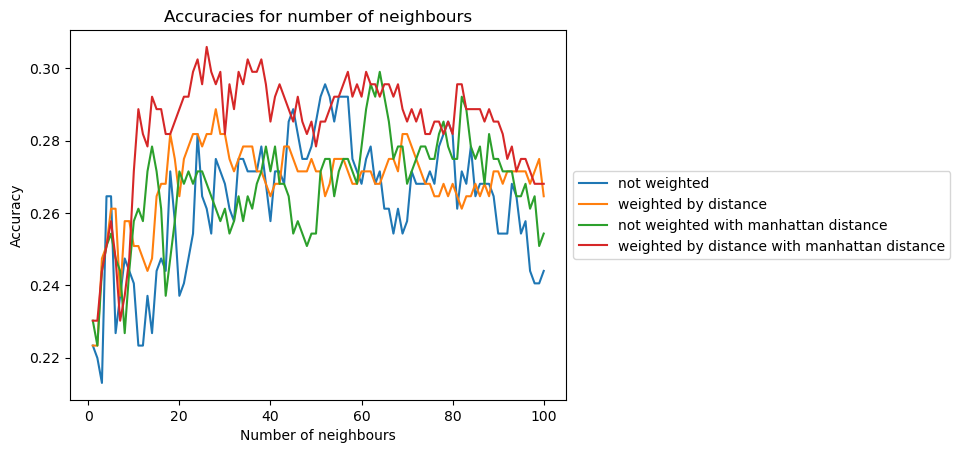

In [87]:
# Create a list of x-values for the parameter variations (e.g., parameter values from 1 to 30)
x_values = list(range(1, num))

# Plot the accuracies
plt.plot(x_values, accu, marker='', label = 'not weighted')
plt.plot(x_values,waccu, marker = '', label = 'weighted by distance')
plt.plot(x_values, l1accu, marker='', label = 'not weighted with manhattan distance')
plt.plot(x_values,l1waccu, marker = '', label = 'weighted by distance with manhattan distance')

# Add labels and title to the plot
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy')
plt.title('Accuracies for number of neighbours')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()


A lot of hyper parameter tuning can be done later but these are the intial results
what we see is that most of them are the same but not weighing and using manhattan instead of euclidean distance is slightly slightly better. The best accuracy we get is 0.313 performed by weighted with manhattan distance with 95 neighbours. This is 5x better than a random choice

In [ ]:
#######################
# kNN ends CNN starts
#######################

In [ ]:
glove_file = '/home/jovyan/persistentt/CSE204/FINAL_PROJECT/glove.6B.100d.txt'
model = KeyedVectors.load_word2vec_format(glove_file)


The glove model we used is Google Glove 6B vector 100d. We have implemented two CNN models using Keras library: i. Simple convolution model: We have implemented a single layer of convoluted and maxpool layer. ii. Dense convolution model: We have implemented multiple convoluted and maxpool layers with filter sizes of 3, 4 and 5.(Figure 3)

We ran the model multiple number of times, changing the following parameters:

learning rate: Modified the learning rate from 1 to 10-7
adjusting the dropout: Adjusted the dropout layers and modified its values
modifying the filter sizes: Used filters of sizes 3,4 and 5
Increasing the number of epochs: Providing enough time for the model to learn
Increasing batch size: Tried batch sizes of 32,64 and 128
In the simple convolutional neural network we could achieve an accuracy of 69.2% and in the dense model we could achieve an accuracy of 71%. Both were run for over a hundred epochs. This is a significant development as compared to the previous two models.

In [ ]:
new_df = df.iloc[:, [0, 4]].copy()
new_df.head()

In [ ]:

## one hot encoding 
artist = new_df.iloc[:, -1].values.copy()
artist = artist.reshape(-1, 1)

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False, categories='auto')

# Fit and transform the 'artist' array using the encoder
artist_encoded = encoder.fit_transform(artist)
artist_encoded

In [ ]:
def generate_song_embedding(song_title):
    embedding_dim = model.vector_size  # Dimensionality of the GloVe word vectors
    embedding = np.zeros(embedding_dim)
    word_count = 0

    for word in song_title:
        if word in model:
            embedding += model[word]
            word_count += 1

    if word_count > 0:
        embedding /= word_count

    return embedding


In [ ]:


# Step 3: Calculate feature importance
feature_importance = np.zeros(X.shape[1])

for feature in range(X.shape[1]):
    X_permuted = X_test.copy()
    np.random.shuffle(X_permuted[:, feature])
    y_pred_permuted = knn.predict(X_permuted)
    accuracy_permuted = np.mean(y_pred_permuted == y_test)
    feature_importance[feature] = accuracy_permuted - knn.score(X_test, y_test)

# Step 4: Visualize feature importance
feature_names = iris.feature_names
plt.bar(feature_names, feature_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in KNN')
plt.xticks(rotation='vertical')
plt.show()


In [ ]:
x_prep = []
for xi in x:
    processed = pre_processing(xi)
    x_prep.append(processed)

testing_size = 50
x_train = x_prep[:-testing_size]
y_train = y[:-testing_size]

x_test = x_prep[-testing_size:]
y_test = y[-testing_size:]
    
documents = [[] for _ in range(len(artists))]   
for i in range(len(x_train)):
    label = y[i]
    documents[label].append(x_train[i])
    
    
for i in range(len(documents)):
    doc = documents[i]
    documents[i] = [word for song in doc for word in song]

        

In [ ]:

def to_numerical(x):
    
    x_numerical = []
    for song in x:
        features = []
        for i in range(len(documents)):
            tfidf = tfidf_scores[i]
            score = 0
            for word in song:
                if word in tfidf.keys():
                    score += tfidf[word]
            features.append(score)
        x_numerical.append(tuple(features))
    return x_numerical


x_train_numerical = to_numerical(x_train)
x_test_numerical = to_numerical(x_test)
    
#plot

x_coord = [x[0] for x in x_train_numerical]
y_coord = [x[1] for x in x_train_numerical]

In [ ]:
knn_sklearn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
knn_sklearn.fit(x_train_numerical, y_train)

In [ ]:
scores = cross_val_score(knn_sklearn, x_train_numerical, y_train, cv=5)
print("Accuracy scores:", scores)

In [ ]:
y_pred = knn_sklearn.predict(x_test_numerical)
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
print(accuracy)

In [ ]:
def confusion_matrix(y_test, y_pred):
    
     
    y_test_labels = [artists[y] for y in y_test]
    y_pred_labels = [artists[y] for y in y_pred]
    

    
    confusion_matrix = metrics.confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)
    
    index_labels = list(map(lambda artist: 'actual ' + artist, artists))

    column_labels = list(map(lambda artist: 'predicted ' + artist, artists))

    df = pd.DataFrame(data=confusion_matrix, index=index_labels, columns=column_labels)
    
    
    df.style.set_properties(**{'width':'6em', 'text-align':'center'}).set_table_styles([dict(selector="th", props=[('text-align', 'center')])])
   
    return df

cfm = confusion_matrix(y_test, y_pred)
cfm

Now we try a more complex approach, with more preprocessing and more features